#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계1 : 데이터 탐색 및 전처리

## 0.미션

* 1) 데이터 탐색
    * intent 별 질문 개수 분포 확인하기
    * 질문 별 문장길이의 분포 확인하기
    * 대화 유형(type) 별 문장길이 분포 비교하기
    * 그 외 필요하다고 판단되는 부분에 대해 데이터를 탐색하고 분석하기
* 2) 전처리
    * 기본 전처리 : 데이터를 불러온 후 다음의 전처리를 먼저 수행합니다.
        * 한글 칼럼이름을 영문이름으로 변경하기
        * 두 데이터셋을 하나로 통합하기
        * intent 번호를 통합된 번호로 만들기
        * 일상대화와 Q&A 대화를 구분하는 구분자 칼럼 추가하기
    * 전처리 결과를 저장합니다.

## 1.환경준비

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.
    - 구글드라이브 를 통해 데이터를 로딩합니다.

### (1) 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

### (2) 데이터 로딩
* 주어진 데이터셋
    * 학습 데이터 : 에이블스쿨문의.xls
    * 학습 데이터 : 일상대화.xls
    * 엑셀 파일이므로 pd.read_excel 함수를 이용해서 불러 옵니다.
* Colab 환경에서 프로젝트 진행을 권장합니다.
    * 구글 드라이브에 project 폴더를 만들고 데이터 파일을 복사해 넣습니다.

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/KT_AIVLE/2023.10.30_미니프로젝트6차

/content/drive/MyDrive/KT_AIVLE/2023.10.30_미니프로젝트6차


### (3) 데이터 읽어오기

In [ ]:
# 일상대화
common_df = pd.read_excel(path + '일상대화.xlsx')

# 에이블스쿨문의
faq_df = pd.read_excel(path + '에이블스쿨문의.xlsx')

* 데이터 둘러보기

In [ ]:
common_df.head()

,intent,질문,답변
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.


In [ ]:
common_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   intent  506 non-null    int64 
 1   질문      506 non-null    object
 2   답변      506 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.0+ KB


In [ ]:
common_df.intent.value_counts().sort_index()

intent
1     16
2     16
3     39
4     10
5     10
6     10
7     10
8     68
9     10
10    10
11    10
12    10
13    24
14    10
15    10
16    10
17    10
18    10
19    10
20    34
21    24
22    10
23    11
24    10
25    10
26    13
27    15
28    28
29    18
30    30
Name: count, dtype: int64

In [ ]:
faq_df.head()

,intent,Q,A
0,0,어떤 조건을 만족하면 지원할 수 있는지 알고 싶어요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
1,0,지원자격이 어떻게 되나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
2,0,지원 조건이 궁금해요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
3,0,지원 자격에 대해서 알려주세요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
4,0,지원 자격 기준이 있나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...


In [ ]:
faq_df.intent.value_counts().sort_index()

intent
0      39
1     138
2      20
3      20
4      20
5      19
6      18
7      20
8      60
9      40
10     40
11     18
12     40
13     20
14     40
15     60
16     20
17     20
18     20
19     60
20     20
21     20
22     20
Name: count, dtype: int64

## 2.데이터 탐색하기


* **세부 요구사항**
    * 데이터에 대한 기본 전처리를 수행합니다.
        * (필요시)한글 칼럼명을 영문명으로 변경,
        * 두 데이터셋 하나로 통합
        * 일상대화와 지원Q&A를 구분할 대화유형(type)칼럼 생성
    * 데이터 탐색하기
        * intent별 질문 수 확인
        * 각 질문별 문장길이에 대한 분포 확인
        * 대화유형(type)별 문장길이 분포 확인
        * 그외, 필요하다고 생각되는 탐색적 분석 수행

### (1) 데이터 기본 전처리

#### 1) column이름 통일하기(선택사항)
* 필수는 아니지만, 한글 칼럼명을 영문으로 변경합니다.

In [ ]:
# common_df의 컬럼 이름을 변경합니다. '질문'을 'Q'로, '답변'을 'A'로 변경
common_df.rename(columns={'질문':'Q','답변':'A'}, inplace=True)
common_df.head()

,intent,Q,A
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.


#### 2) 데이터셋 통합
* intent 다시 번호 부여하기
    * 두 데이터의 intent 번호를 확인합니다.
    * 변경
        * common_df : 1 부터 시작되도록 하고
        * faq_df : common_df의 마지막 intent 이후부터 시작되도록 수정
* 두 데이터 셋을 통합합니다. (pd.concat)

* intent 번호 조정

In [ ]:
common_df.intent.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [ ]:
faq_df.intent.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [ ]:
len(common_df.intent.unique())

30

In [ ]:
faq_df['intent']+=len(common_df.intent.unique())+1
faq_df.head()

,intent,Q,A
0,31,어떤 조건을 만족하면 지원할 수 있는지 알고 싶어요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
1,31,지원자격이 어떻게 되나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
2,31,지원 조건이 궁금해요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
3,31,지원 자격에 대해서 알려주세요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
4,31,지원 자격 기준이 있나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...


In [ ]:
faq_df.intent.unique()

array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53])

* 데이터셋 통합(pd.concat)

In [ ]:
data=pd.concat([common_df,faq_df])

In [ ]:
data

,intent,Q,A
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.
...,...,...,...
787,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
788,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
789,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
790,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...


#### 3) 일상대화와 Q&A대화 구분 칼럼(대화유형) 만들기
* 주어진 데이터셋은 두가지 종류입니다.
* 통합 데이터에 type 칼럼을 추가하고, 일상대화를 0, Q&A를 1로 지정하시오.

In [ ]:
data['type']=np.where(data['intent']<=len(common_df.intent.unique()),0,1)

In [ ]:
data[data['intent']<=len(common_df.intent.unique())]

,intent,Q,A,type
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0
1,1,액정 나갔어,as 맡기세요.,0
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0
...,...,...,...,...
501,30,나 오늘 생일이야~,기분 좋겠어요.,0
502,30,원하던 대학교에 합격했어,기분 좋겠어요.,0
503,30,편입 성공했어!!,기분 좋겠어요.,0
504,30,고백 성공해서 오늘부터 1일이야~,기분 좋겠어요.,0


In [ ]:
data[data['intent']>len(common_df.intent.unique())]

,intent,Q,A,type
0,31,어떤 조건을 만족하면 지원할 수 있는지 알고 싶어요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...,1
1,31,지원자격이 어떻게 되나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...,1
2,31,지원 조건이 궁금해요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...,1
3,31,지원 자격에 대해서 알려주세요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...,1
4,31,지원 자격 기준이 있나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...,1
...,...,...,...,...
787,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
788,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
789,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
790,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1


### (2) 데이터 탐색하기


* 세부 요구사항
    - intent별 질문 개수 분포를 확인합니다.
        * 문의 유형별 길이에 대한 기초통계량과  시각화(히스토그램, 박스플롯 등)를 통해 분포를 확인합니다.
    - 질문별 문장 길이 분포를 확인합니다.

#### 1) intent별 질문 개수 살펴보기
* intent 별 데이터 개수를 bar plot 등을 이용하여 시각화 합니다.

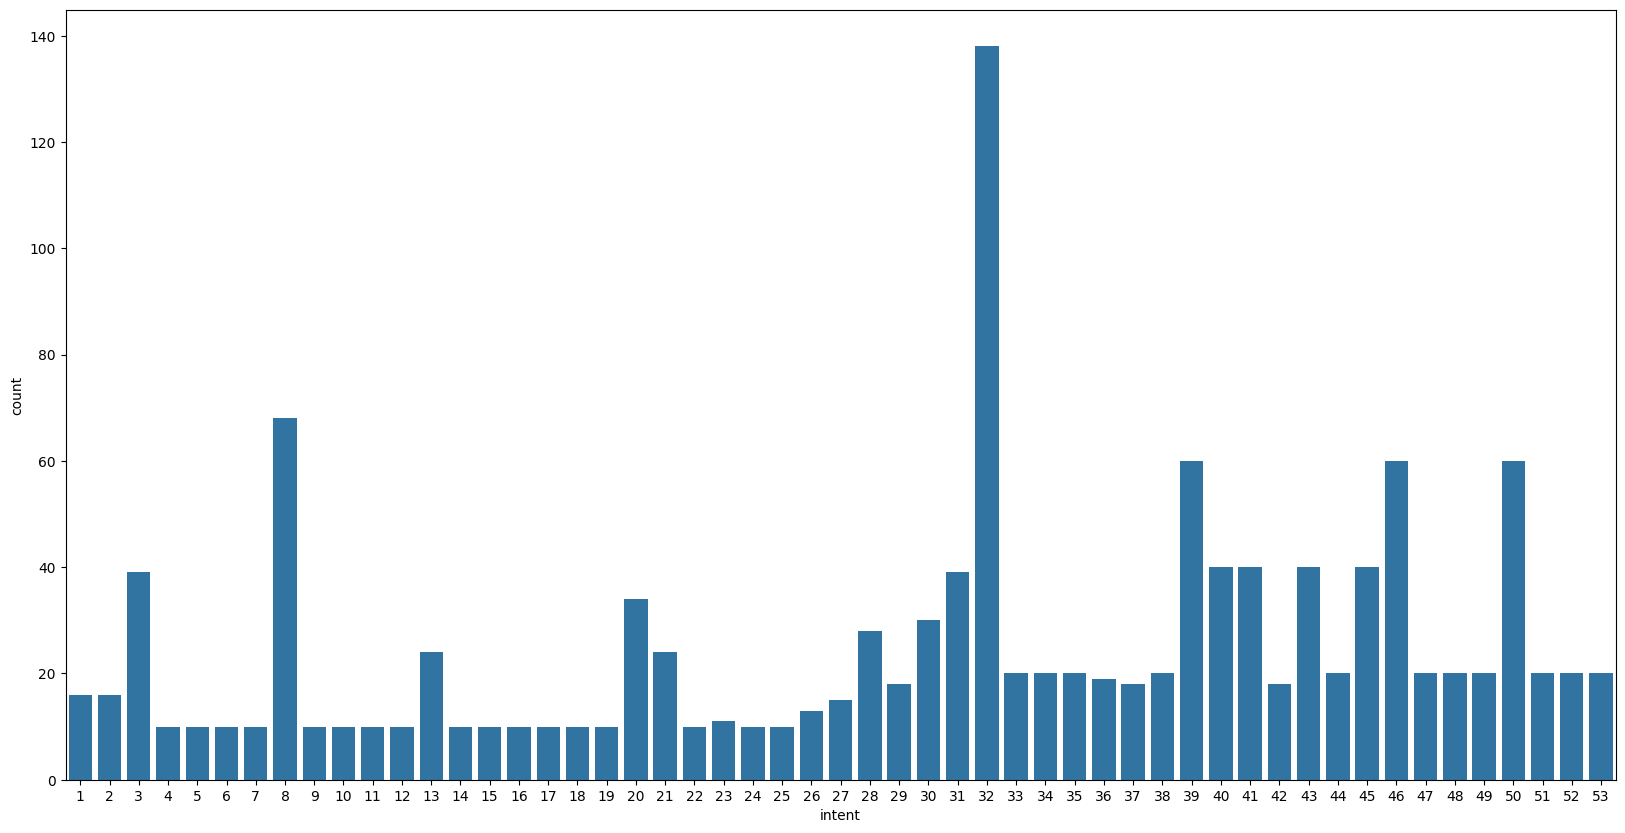

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x='intent', data=data)
plt.show()

#### 2) 질문별 문장 길이 분포
* 질문 별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

In [ ]:
data['Q'].apply(lambda x : len(x)).describe()

count    1298.000000
mean       18.246533
std        10.605533
min         3.000000
25%        11.000000
50%        16.000000
75%        23.000000
max       127.000000
Name: Q, dtype: float64

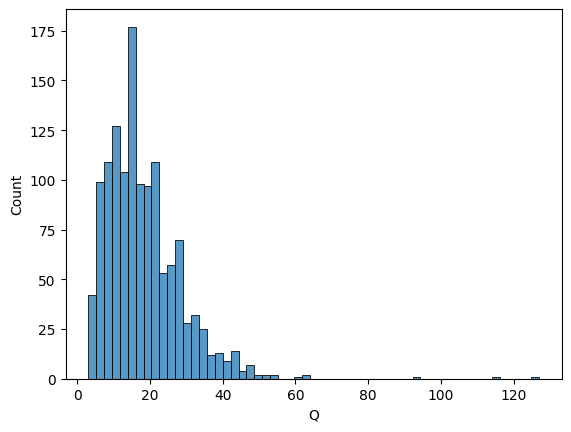

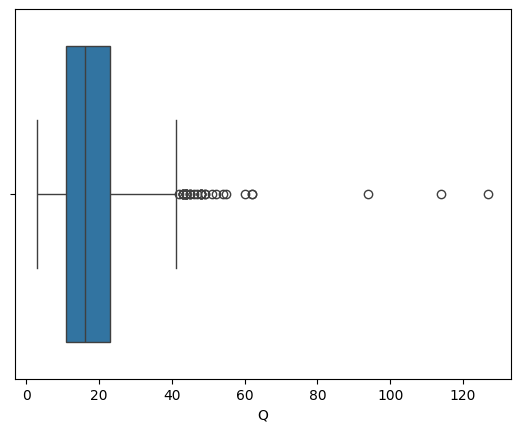

In [ ]:
sns.histplot(data['Q'].apply(lambda x : len(x)))
plt.show()
sns.boxplot(x=data['Q'].apply(lambda x : len(x)))
plt.show()

#### 3) 대화 유형(type) 별 문장 길이 분포 비교
* 타입별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

In [ ]:
print(data.loc[data.type==0].Q.apply(lambda x : len(x)).describe(), '\n')
print(data.loc[data.type==1].Q.apply(lambda x : len(x)).describe())

count    506.000000
mean      10.126482
std        3.971658
min        3.000000
25%        7.000000
50%       10.000000
75%       12.000000
max       28.000000
Name: Q, dtype: float64 

count    792.000000
mean      23.434343
std       10.258270
min        6.000000
25%       17.000000
50%       21.000000
75%       28.000000
max      127.000000
Name: Q, dtype: float64


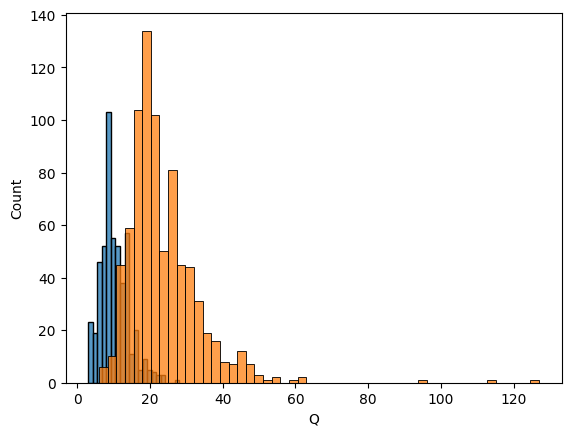

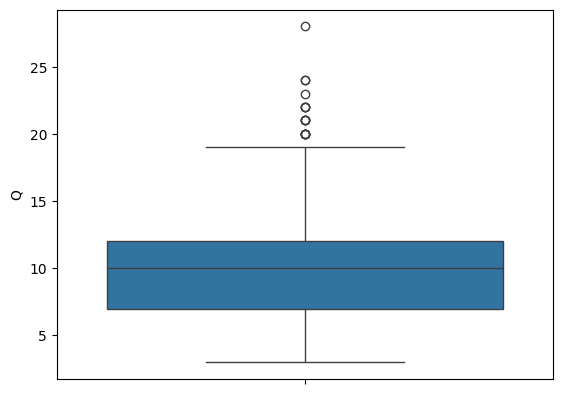

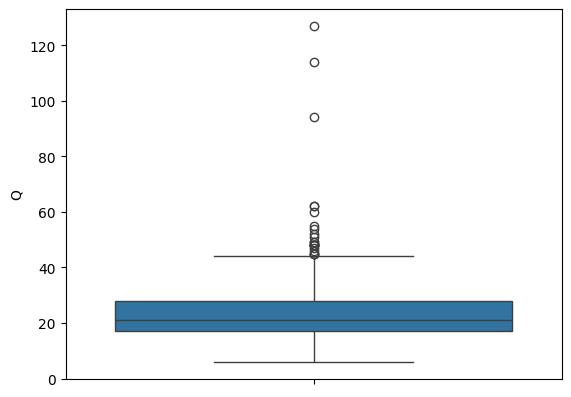

In [ ]:
sns.histplot(data.loc[data.type==0].Q.apply(lambda x : len(x)))
sns.histplot(data.loc[data.type==1].Q.apply(lambda x : len(x)))
plt.show()
sns.boxplot(data.loc[data.type==0].Q.apply(lambda x : len(x)))
plt.show()
sns.boxplot(data.loc[data.type==1].Q.apply(lambda x : len(x)))
plt.show()

### (3) 기본 전처리 완료된 데이터를 파일로 저장하기
- 총 1개의 파일을 저장합니다.
    * data 셋
- 저장방법
    * joblib 라이브러리를 이용하여 저장합니다.

In [ ]:
joblib.dump(data, 'data')

['/content/drive/MyDrive/KT_AIVLE/2023.10.30_미니프로젝트6차_실습자료 및 데이터/data']